In [151]:
# This notebook intends to compare metrics against 
# available validation datasets. The main goal is
# to generate performance curves as well as thresholds
# for the different metrics and events.  

In [152]:
import yaml
import math
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

### Select event & define paths to data

In [153]:
EVENT_NAME = 'chile_fire_2024'
TRACK_IDX = 0
METRIC_IDX = 6 # options [0, 1, 2, 3, 4, 5, 6] for [CUSUM_PROB_MAX, CUSUM_VH, LOG_RATIO, MAHALANOBIS_1D_MAX, MAHALANOBIS_2D, MAHALANOBIS_VH, TRANSFORMER] respectively
dist_events_dir = Path('/u/aurora-r0/cmarshak/dist-s1-events')
dist_metrics_dir = Path('/u/aurora-r0/cmarshak/dist-s1-calibration/out_metrics')

print(dist_events_dir, dist_metrics_dir)

/u/aurora-r0/cmarshak/dist-s1-events /u/aurora-r0/cmarshak/dist-s1-calibration/out_metrics


In [154]:
# Read event info
yaml_file = dist_events_dir / f'events/{EVENT_NAME}.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 180,
 'post_event_window_days': 100,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'source_id': 'EMSR715 AOI1',
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

In [155]:
# Get date and tracks
EVENT_DATE = event_dict['event_date']
TRACKS = event_dict['rtc_track_numbers']
print('Event date:', EVENT_DATE)
print('Tracks:', TRACKS)

Event date: 2024-02-04
Tracks: [18, 156]


In [156]:
# Event data
EVENT_DATA = dist_events_dir / 'out' / EVENT_NAME
# set up out directory
# # OUT_DIR = EVENT_DATA / 'out'
# OUT_DIR, OUT_DIR.exists()

In [157]:
# Get preprocessed datasets for specified event
RTC_DIR = EVENT_DATA / 'rtc_ts_merged'
DIST_HLS_CM_DIR = EVENT_DATA / 'change_map_dist_hls'
WATER_MASK_DIR = EVENT_DATA / 'water_mask'
VAL_DATA_DIR = EVENT_DATA / 'validation_data'
all([d.exists() for d in [RTC_DIR, DIST_HLS_CM_DIR, WATER_MASK_DIR, VAL_DATA_DIR]])

True

In [158]:
# Get paths to metrics
track_number = f'track{TRACKS[TRACK_IDX]}'
EVENT_METRICS = dist_metrics_dir / EVENT_NAME / track_number 

CUSUM_PROB_MAX = EVENT_METRICS /'cusum_prob_max'
CUSUM_VH = EVENT_METRICS / 'cusum_vh'
LOG_RATIO = EVENT_METRICS / 'log_ratio_vh'
MAHALANOBIS_1D_MAX = EVENT_METRICS / 'mahalanobis_1d_max'
MAHALANOBIS_2D = EVENT_METRICS / 'mahalanobis_2d'
MAHALANOBIS_VH = EVENT_METRICS / 'mahalanobis_vh'
TRANSFORMER = EVENT_METRICS / 'transformer'

METRIC_LIST = [CUSUM_PROB_MAX, CUSUM_VH, LOG_RATIO, MAHALANOBIS_1D_MAX, 
               MAHALANOBIS_2D, MAHALANOBIS_VH, TRANSFORMER]

all([d.exists() for d in METRIC_LIST])


True

### Read validation data

In [159]:
# Read validation data
val_data_paths = list(VAL_DATA_DIR.glob('*.tif'))
aoi_path = [p for p in val_data_paths if 'extent_datamask' in p.stem][0]
val_path = [p for p in val_data_paths if 'extent' not in p.stem][0]

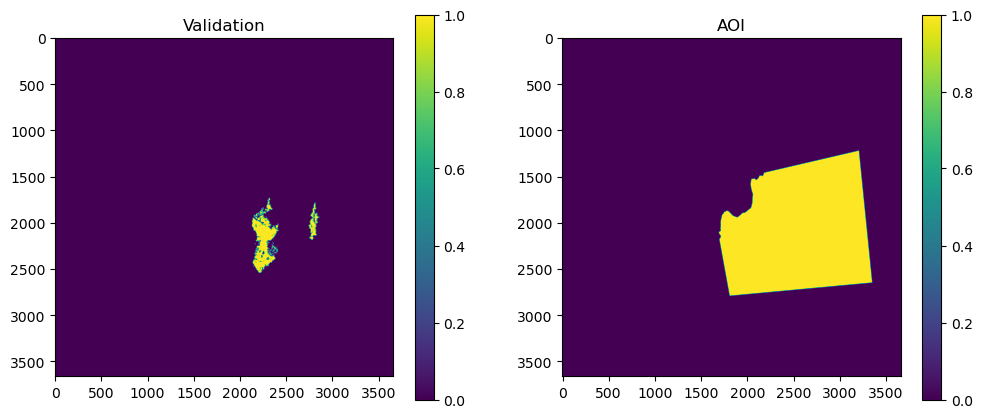

In [160]:
# Visualize validation
with rio.open(val_path) as ds:
    X_val = ds.read(1)
    p_val = ds.profile

with rio.open(aoi_path) as ds:
    X_aoi = ds.read(1)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
cax = ax.imshow(X_val)
ax.set_title("Validation")
cbar = fig.colorbar(cax, orientation='vertical')
ax = fig.add_subplot(1, 2, 2)
cax = ax.imshow(X_aoi)
ax.set_title("AOI")
cbar = fig.colorbar(cax, orientation='vertical')
plt.show()

### Read water mask

In [161]:
# Read water mask
water_path = WATER_MASK_DIR / 'water_mask.tif'
water_path.exists()

True

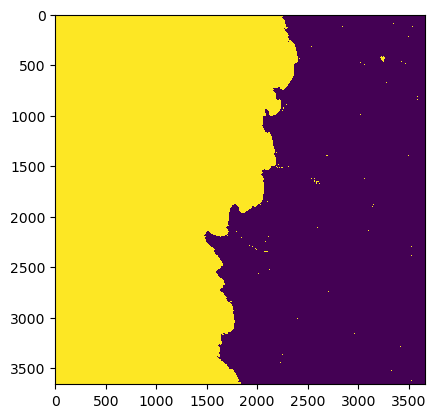

In [162]:
with rio.open(water_path) as ds:
    X_water = ds.read(1)

plt.imshow(X_water, interpolation='none')
plt.show()

### Read metrics

In [163]:
# Events
pre_metric_paths = sorted(list(METRIC_LIST[METRIC_IDX].glob('pre*.tif')))
pre_metric_names = [file.stem for file in pre_metric_paths]
post_metric_paths = sorted(list(METRIC_LIST[METRIC_IDX].glob('post*.tif'))) 
post_metric_names = [file.stem for file in post_metric_paths]



In [164]:
# load arrays
pre_metric_list = []
for file in pre_metric_paths:
    with rio.open(file) as src:
        array = src.read(1)
        pre_metric_list.append(array)

post_metric_list = []
for file in post_metric_paths:
    with rio.open(file) as src:
        array = src.read(1)
        post_metric_list.append(array)

print(len(pre_metric_list), len(post_metric_list))
print(pre_metric_list[0].shape)

2 2
(3660, 3660)


In [165]:
# Create zoom slice
def zoom_slice(mask, buffer_size=100):
    n_rows, n_cols = mask.shape
    rows, cols = np.nonzero(mask)
    # Find the min and max of row and column indices
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()
    # Apply the buffer to the window
    row_min = max(0, row_min - buffer_size)
    row_max = min(n_rows - 1, row_max + buffer_size)
    col_min = max(0, col_min - buffer_size)
    col_max = min(n_cols - 1, col_max + buffer_size)
    # create slice 
    slice = np.s_[row_min:row_max + 1, col_min:col_max + 1]

    return slice


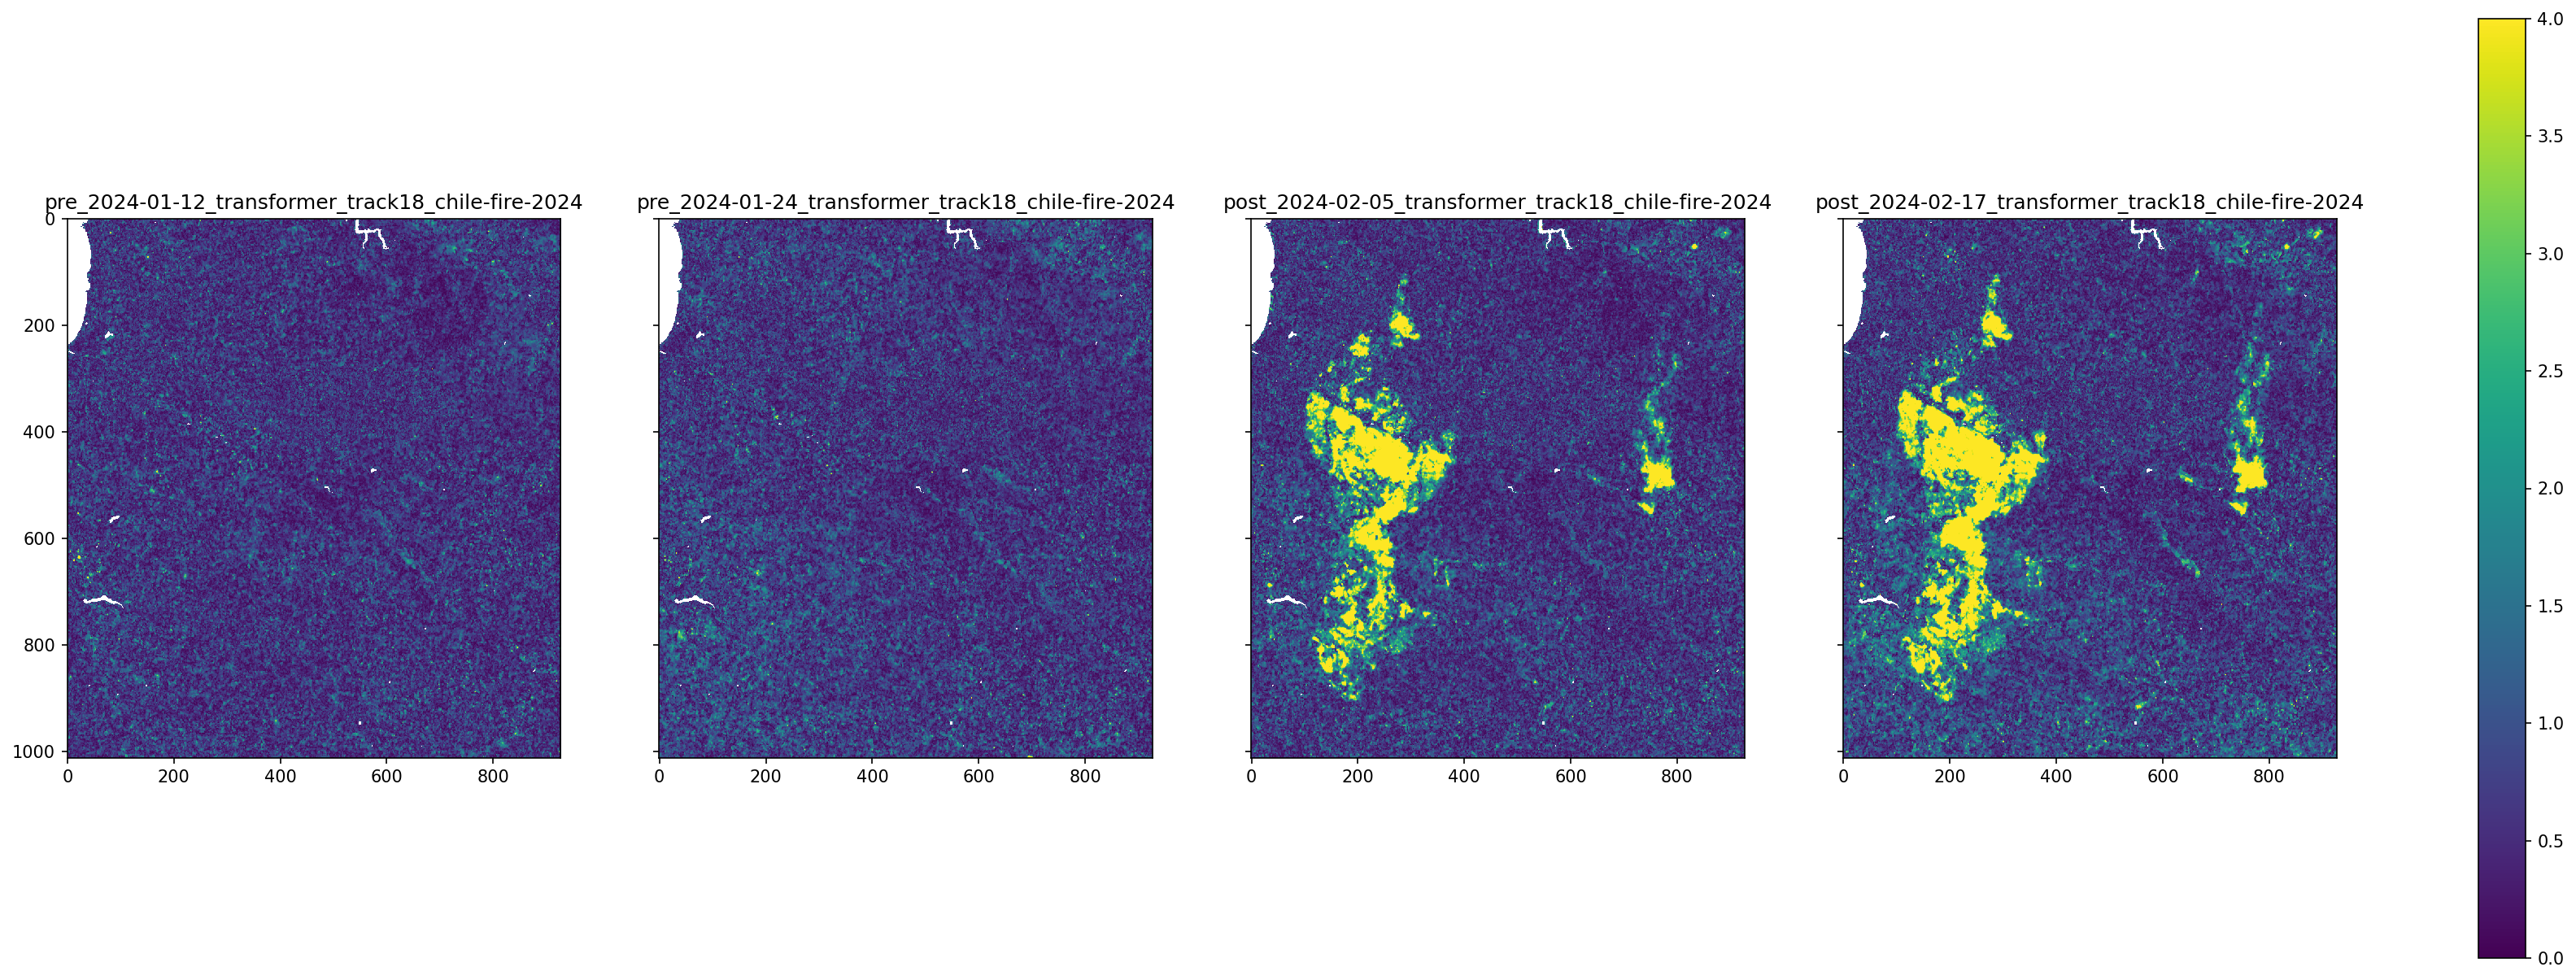

In [166]:
# visualize metrics 
s = zoom_slice(X_val)
metrics = [pre_metric_list[0],
           pre_metric_list[1],
           post_metric_list[0],
           post_metric_list[1]]
metric_names = pre_metric_names + post_metric_names
N = len(metrics)

fig, axs = plt.subplots(1, N, figsize=(10 + N * 5, 10), dpi=150, sharey=True)

for ax, met, mn in zip(axs, metrics, metric_names):
    im = ax.imshow(met[s], vmin=0, vmax=4, interpolation='none')
    ax.set_title(mn)
fig.colorbar(im, ax=axs.ravel().tolist())

### Compare metrics against validation

In [167]:
def make_aoi_mask(metric, aoi_region):
    '''
    AOI for validation 
    '''
    aoi_mask = aoi_region.astype(bool) & (~np.isnan(metric))

    return aoi_mask


def jaccard_similarity(a, b):
    """
    Compute the Jaccard similarity coefficient (intersect-over-union) of two boolean
    arrays.
    Parameters
    ----------
    a, b : numpy array
        The input binary masks.
    Returns
    -------
    J : float
        The Jaccard similarity coefficient of the two inputs.
    """
    a = np.asanyarray(a, dtype=np.bool_)
    b = np.asanyarray(b, dtype=np.bool_)

    return np.sum(a & b) / np.sum(a | b)



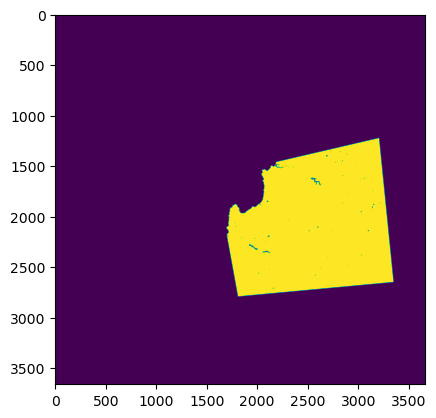

In [168]:
# get curves for each case
aoi_mask = make_aoi_mask(post_metric_list[0], X_aoi)
plt.imshow(aoi_mask)

In [169]:
# Calculate precision recall and f1score
# Concat metric arrays
metric_aoi_con = np.concatenate([lst[aoi_mask] for lst in [post_metric_list[0], post_metric_list[1], pre_metric_list[0], pre_metric_list[1]]], axis=0)
# Concat validation arrays
change_val = X_val[aoi_mask]
change_val_con = np.concatenate([change_val, change_val, np.zeros(change_val.shape), np.zeros(change_val.shape)], axis=0)

precisions, recalls, thresholds = precision_recall_curve(change_val_con, metric_aoi_con)
f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-7)
k_max = np.argmax(f1_scores)
f1_max = f1_scores[k_max]

In [170]:
# Calculate ROC curve
fprs, tprs, _ = roc_curve(change_val_con, metric_aoi_con)
auc = roc_auc_score(change_val_con, metric_aoi_con)

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_218452/2102466323.py:12: SyntaxWarning: invalid escape sequence '\m'
  axs[0].annotate(f'$\max(F_1)=${f1_max:1.2f}', (recalls[k_max] + 0.01, precisions[k_max] + 0.01),
/tmp/ipykernel_218452/2102466323.py:20: SyntaxWarning: invalid escape sequence '\m'
  axs[1].annotate(f'$\max(F_1)=${f1_max:1.2f}', (thresholds[k_max] + 0.02, f1_scores[k_max] + 0.01),


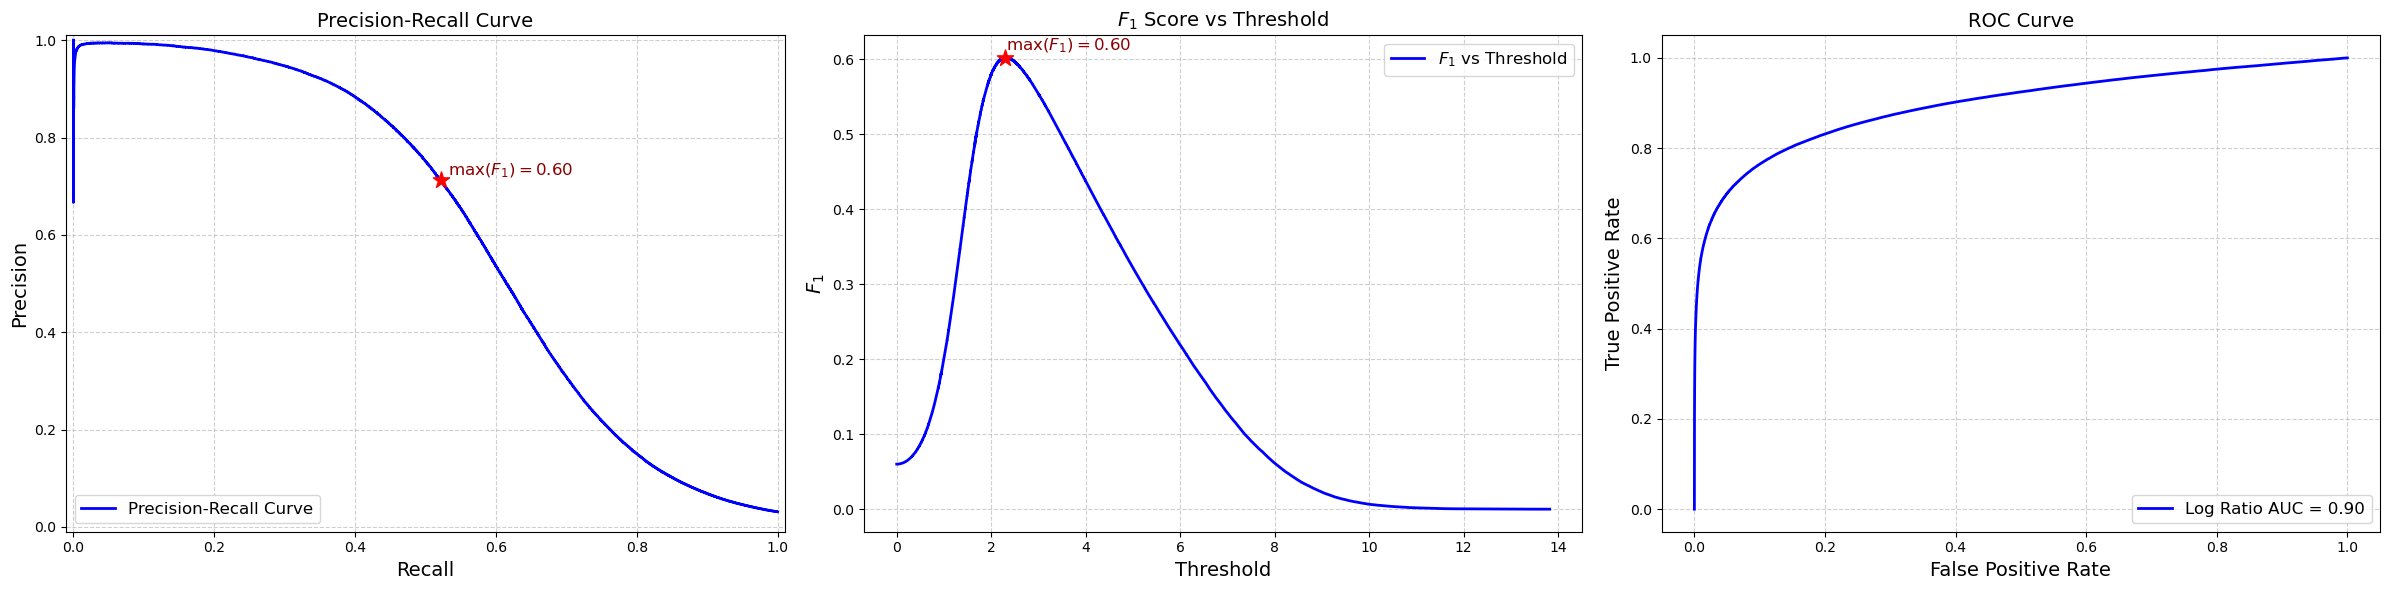

In [171]:
# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  

# Plot 1: Precision-Recall Curve
axs[0].plot(recalls[:-1], precisions[:-1], label='Precision-Recall Curve', linewidth=2, color='blue')
axs[0].set_xlim(-0.01, 1.01)
axs[0].set_ylim(-0.01, 1.01)
axs[0].set_ylabel('Precision', fontsize=14)
axs[0].set_xlabel('Recall', fontsize=14)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].scatter(recalls[k_max], precisions[k_max], marker='*', c='red', s=150, zorder=3)
axs[0].annotate(f'$\max(F_1)=${f1_max:1.2f}', (recalls[k_max] + 0.01, precisions[k_max] + 0.01), 
                fontsize=12, color='darkred')
axs[0].set_title('Precision-Recall Curve', fontsize=14)
axs[0].legend(loc='lower left', fontsize=12)

# Plot 2: F1 Score vs Threshold
axs[1].plot(thresholds, f1_scores[:-1], label='$F_1$ vs Threshold', linewidth=2, color='blue')
axs[1].scatter(thresholds[k_max], f1_scores[k_max], marker='*', c='red', s=150, zorder=3)
axs[1].annotate(f'$\max(F_1)=${f1_max:1.2f}', (thresholds[k_max] + 0.02, f1_scores[k_max] + 0.01),
                fontsize=12, color='darkred')
axs[1].set_title('$F_1$ Score vs Threshold', fontsize=14)
axs[1].set_ylabel('$F_1$', fontsize=14)
axs[1].set_xlabel('Threshold', fontsize=14)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend(loc='best', fontsize=12)
axs[1].set_xlim(axs[1].get_xlim())  # Ensure consistent x-limits

# Plot 3: ROC Curve
axs[2].plot(fprs, tprs, label=f'Log Ratio AUC = {auc:1.2f}', linewidth=2, color='blue')
axs[2].set_xlabel('False Positive Rate', fontsize=14)
axs[2].set_ylabel('True Positive Rate', fontsize=14)
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].legend(loc='lower right', fontsize=12)
axs[2].set_title('ROC Curve', fontsize=14)

plt.tight_layout()
plt.show()


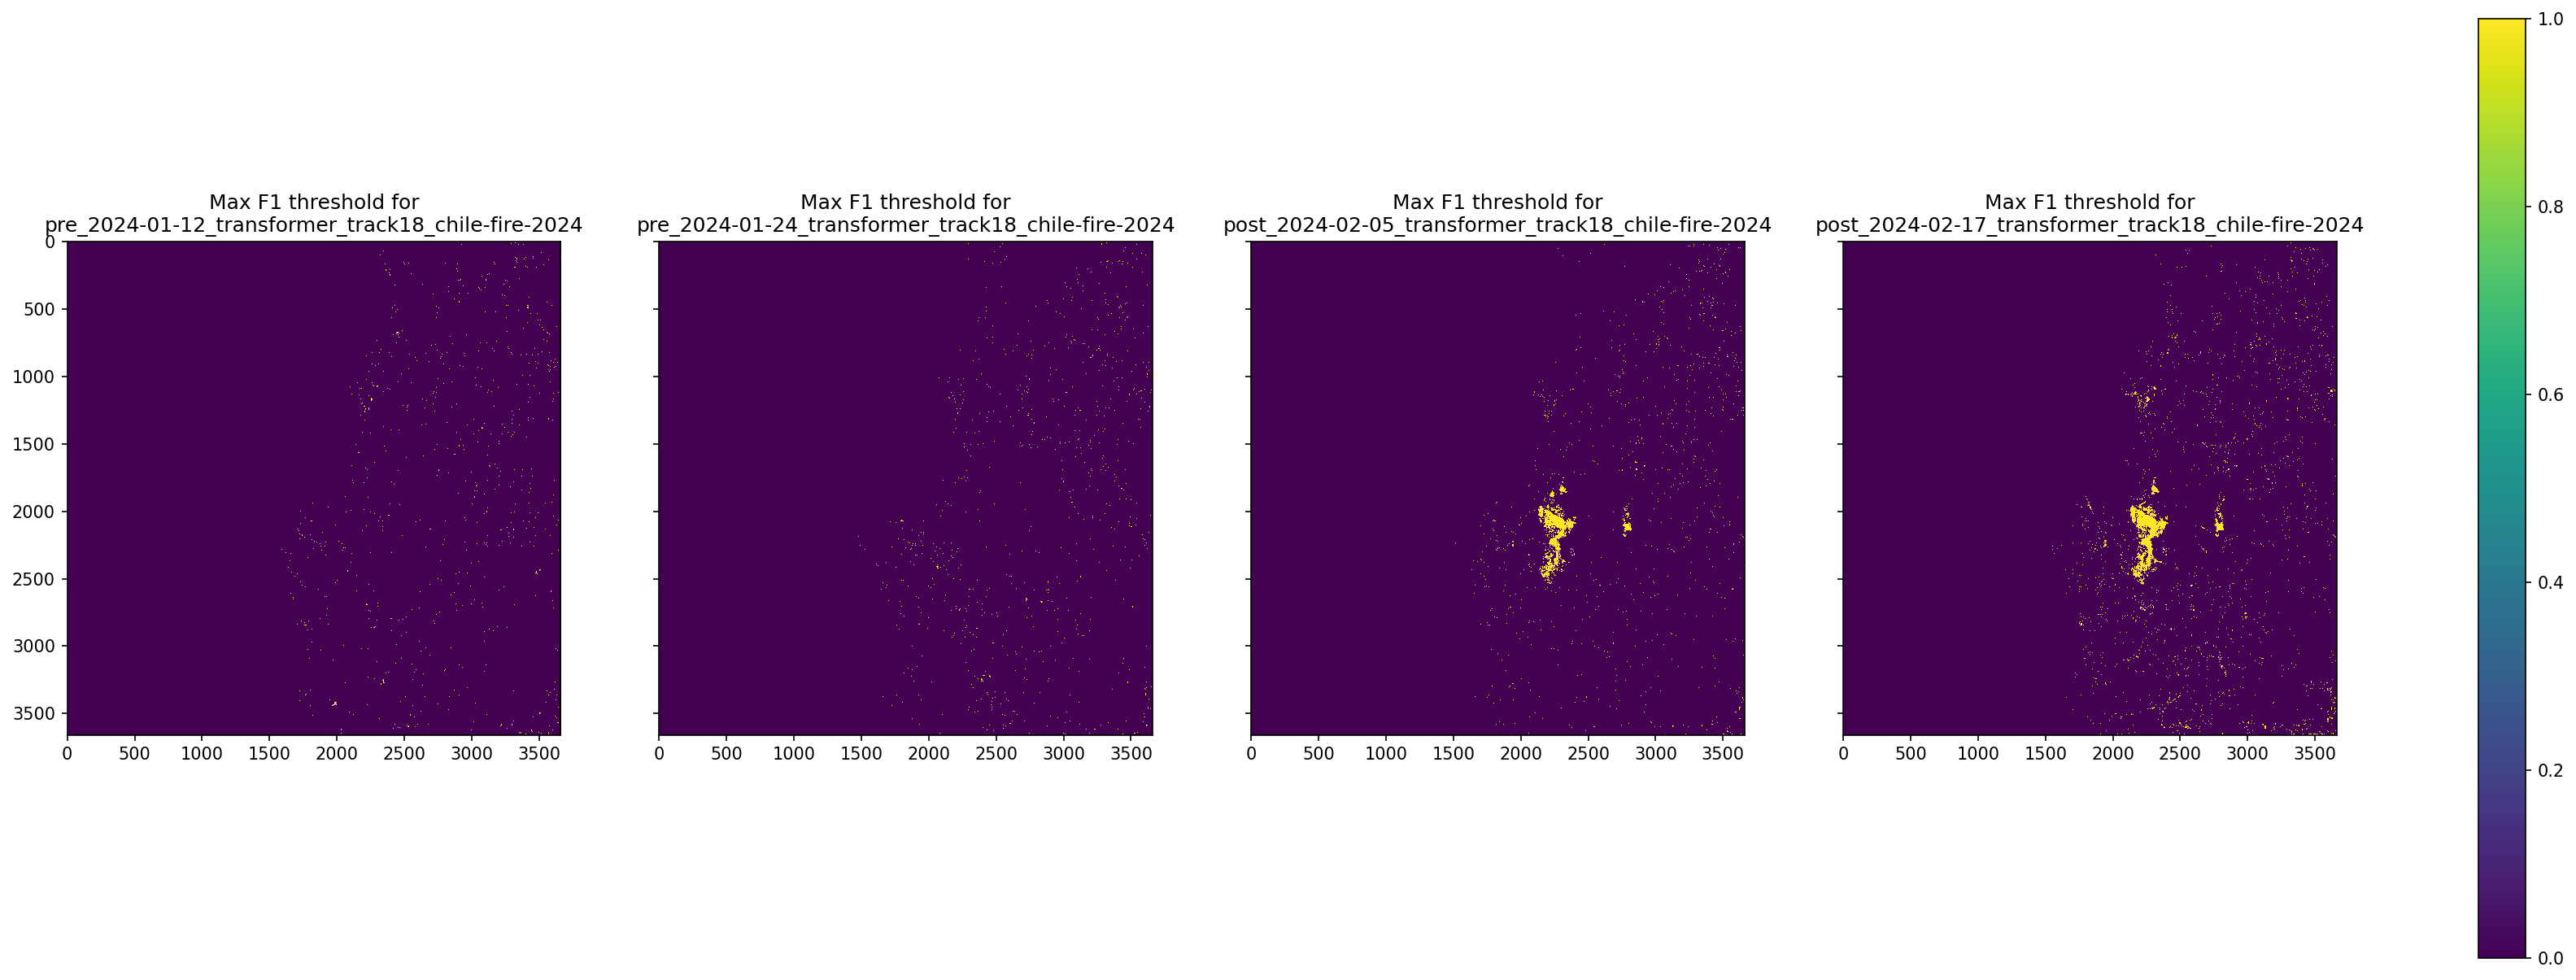

In [172]:
# visualize thresholded metrics
thresholded = [pre_metric_list[0] > thresholds[k_max],
               pre_metric_list[1] > thresholds[k_max],
               post_metric_list[0] > thresholds[k_max],
               post_metric_list[1] > thresholds[k_max]]
thresholded_names = [f"Max F1 threshold for\n{metric_names[0]}",
                    f"Max F1 threshold for\n{metric_names[1]}",
                    f"Max F1 threshold for\n{metric_names[2]}",
                    f"Max F1 threshold for\n{metric_names[3]}"]

N = len(thresholded)

fig, axs = plt.subplots(1, N, figsize=(10 + N * 5, 10), dpi=150, sharey=True)

for ax, met, mn in zip(axs, thresholded, thresholded_names):
    im = ax.imshow(met, vmin=0, vmax=1, interpolation='none')
    ax.set_title(mn)
fig.colorbar(im, ax=axs.ravel().tolist())

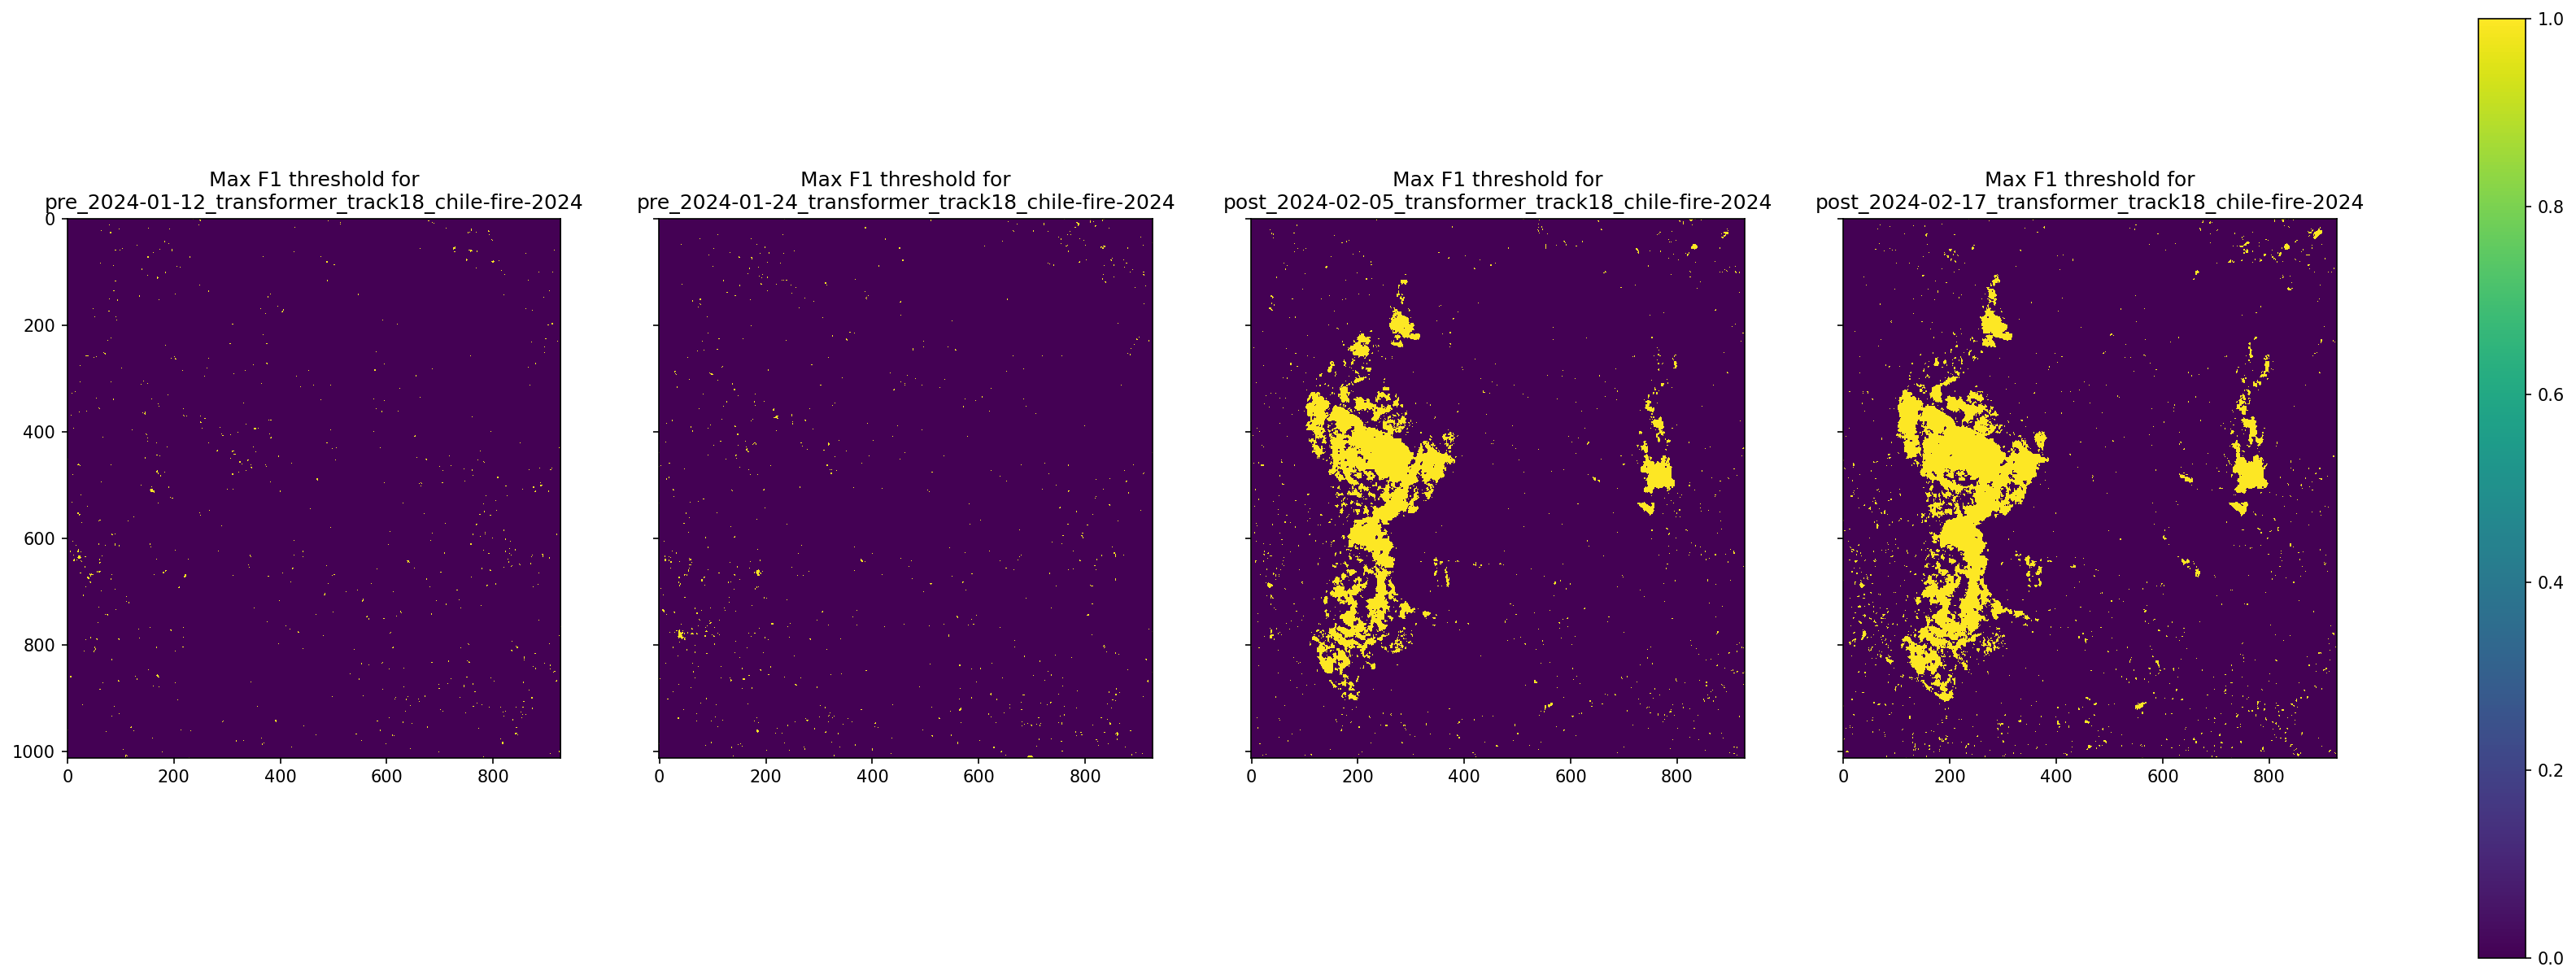

In [173]:
# visualize thresholded metrics zoomed in to validation region
thresholded = [pre_metric_list[0] > thresholds[k_max],
               pre_metric_list[1] > thresholds[k_max],
               post_metric_list[0] > thresholds[k_max],
               post_metric_list[1] > thresholds[k_max]]
thresholded_names = [f"Max F1 threshold for\n{metric_names[0]}",
                    f"Max F1 threshold for\n{metric_names[1]}",
                    f"Max F1 threshold for\n{metric_names[2]}",
                    f"Max F1 threshold for\n{metric_names[3]}"]

N = len(thresholded)

fig, axs = plt.subplots(1, N, figsize=(10 + N * 5, 10), dpi=150, sharey=True)

for ax, met, mn in zip(axs, thresholded, thresholded_names):
    im = ax.imshow(met[s], vmin=0, vmax=1, interpolation='none')
    ax.set_title(mn)
fig.colorbar(im, ax=axs.ravel().tolist())

In [174]:
# Jaccard similarity indexes
jaccard_post0 = jaccard_similarity(thresholded[2], X_val)
jaccard_post1 = jaccard_similarity(thresholded[3], X_val)

jaccard_coeff = [jaccard_post0, jaccard_post1]
print(jaccard_coeff)

[np.float64(0.36437431891888367), np.float64(0.3543711918234765)]


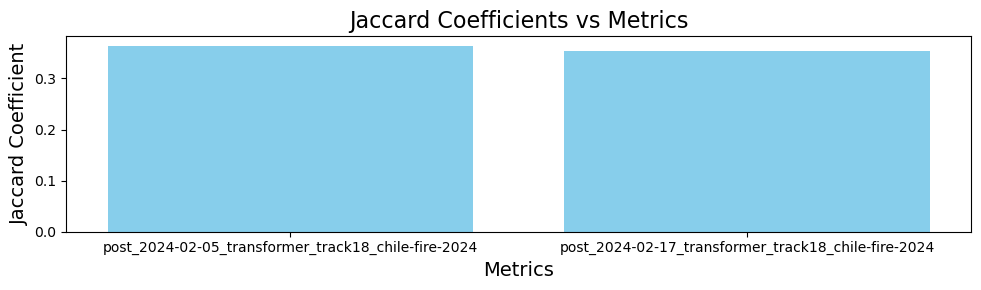

In [175]:
# Graph jaccard similarity 
plt.figure(figsize=(10, 3))
plt.bar(post_metric_names, jaccard_coeff, color='skyblue')
plt.ylabel('Jaccard Coefficient', fontsize=14)
plt.xlabel('Metrics', fontsize=14)
plt.title('Jaccard Coefficients vs Metrics', fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Compare with Dist-HLS

In [176]:
# Get Dist HLS data
dist_hls_paths = list(DIST_HLS_CM_DIR.glob('*.tif'))
dist_hls_names = [file.stem for file in dist_hls_paths]
dist_hls_names

['dist_hls_confirmed_change_map_veg_first2024-03-06',
 'dist_hls_confirmed_change_map_gen_first2024-03-06',
 'dist_hls_provisional_change_map_veg_first2024-02-05',
 'dist_hls_provisional_change_map_gen_first2024-02-05',
 'dist_hls_confirmed_change_map_veg_first2024-05-10',
 'dist_hls_confirmed_change_map_gen_first2024-05-10']

In [177]:
# Load Dist-HLS
dist_hls_list = []
for file in dist_hls_paths:
    with rio.open(file) as src:
        array = src.read(1)
        array = np.where((array == 0) | (array == 1), array, 0).astype(np.uint8)
        dist_hls_list.append(array)

print(len(dist_hls_list), dist_hls_list[0].shape)

6 (3660, 3660)


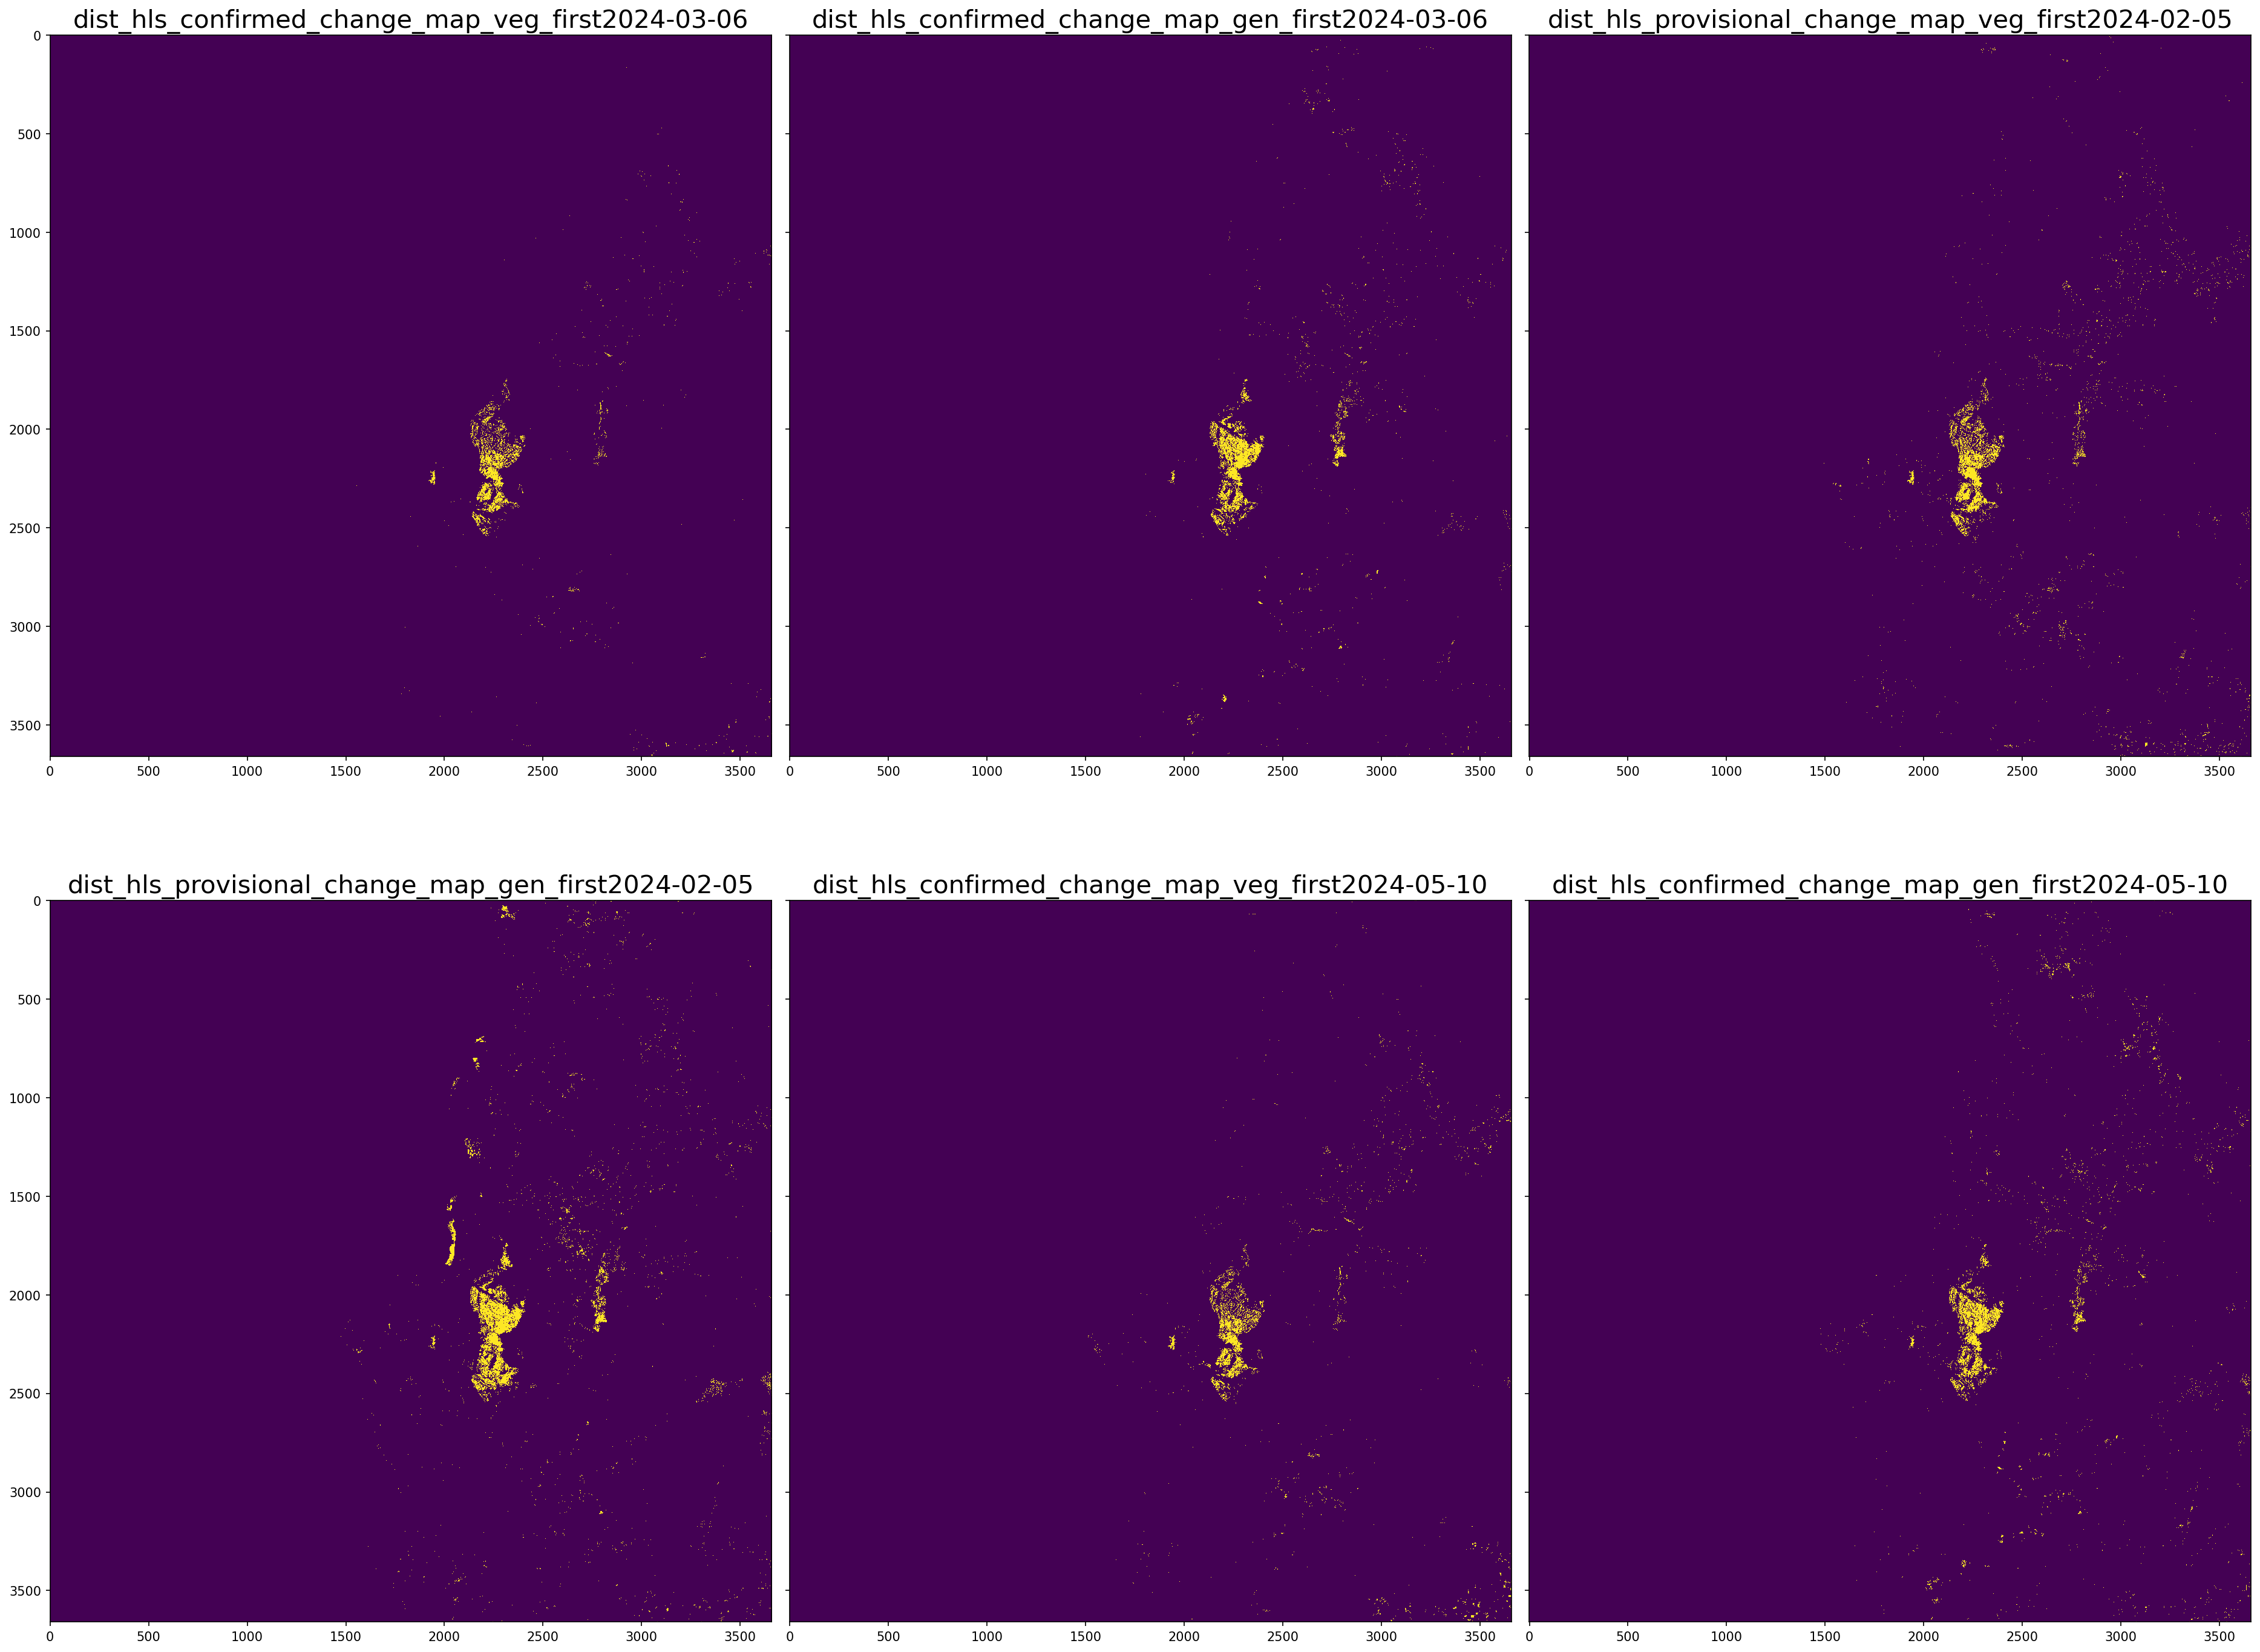

In [178]:
N = len(dist_hls_list)
ncols = math.ceil(N / 2) 
nrows = 2 

fig, axs = plt.subplots(nrows, ncols, figsize=(10 + ncols * 5, 10 + nrows * 5), dpi=150, sharey=True)

# Flatten axs if N is odd or if N doesn't divide equally into two rows
axs = axs.flatten()

for ax, met, mn in zip(axs, dist_hls_list, dist_hls_names):
    im = ax.imshow(met, vmin=0, vmax=1, interpolation='none')
    ax.set_title(mn, fontsize=20)

plt.tight_layout()
plt.show()


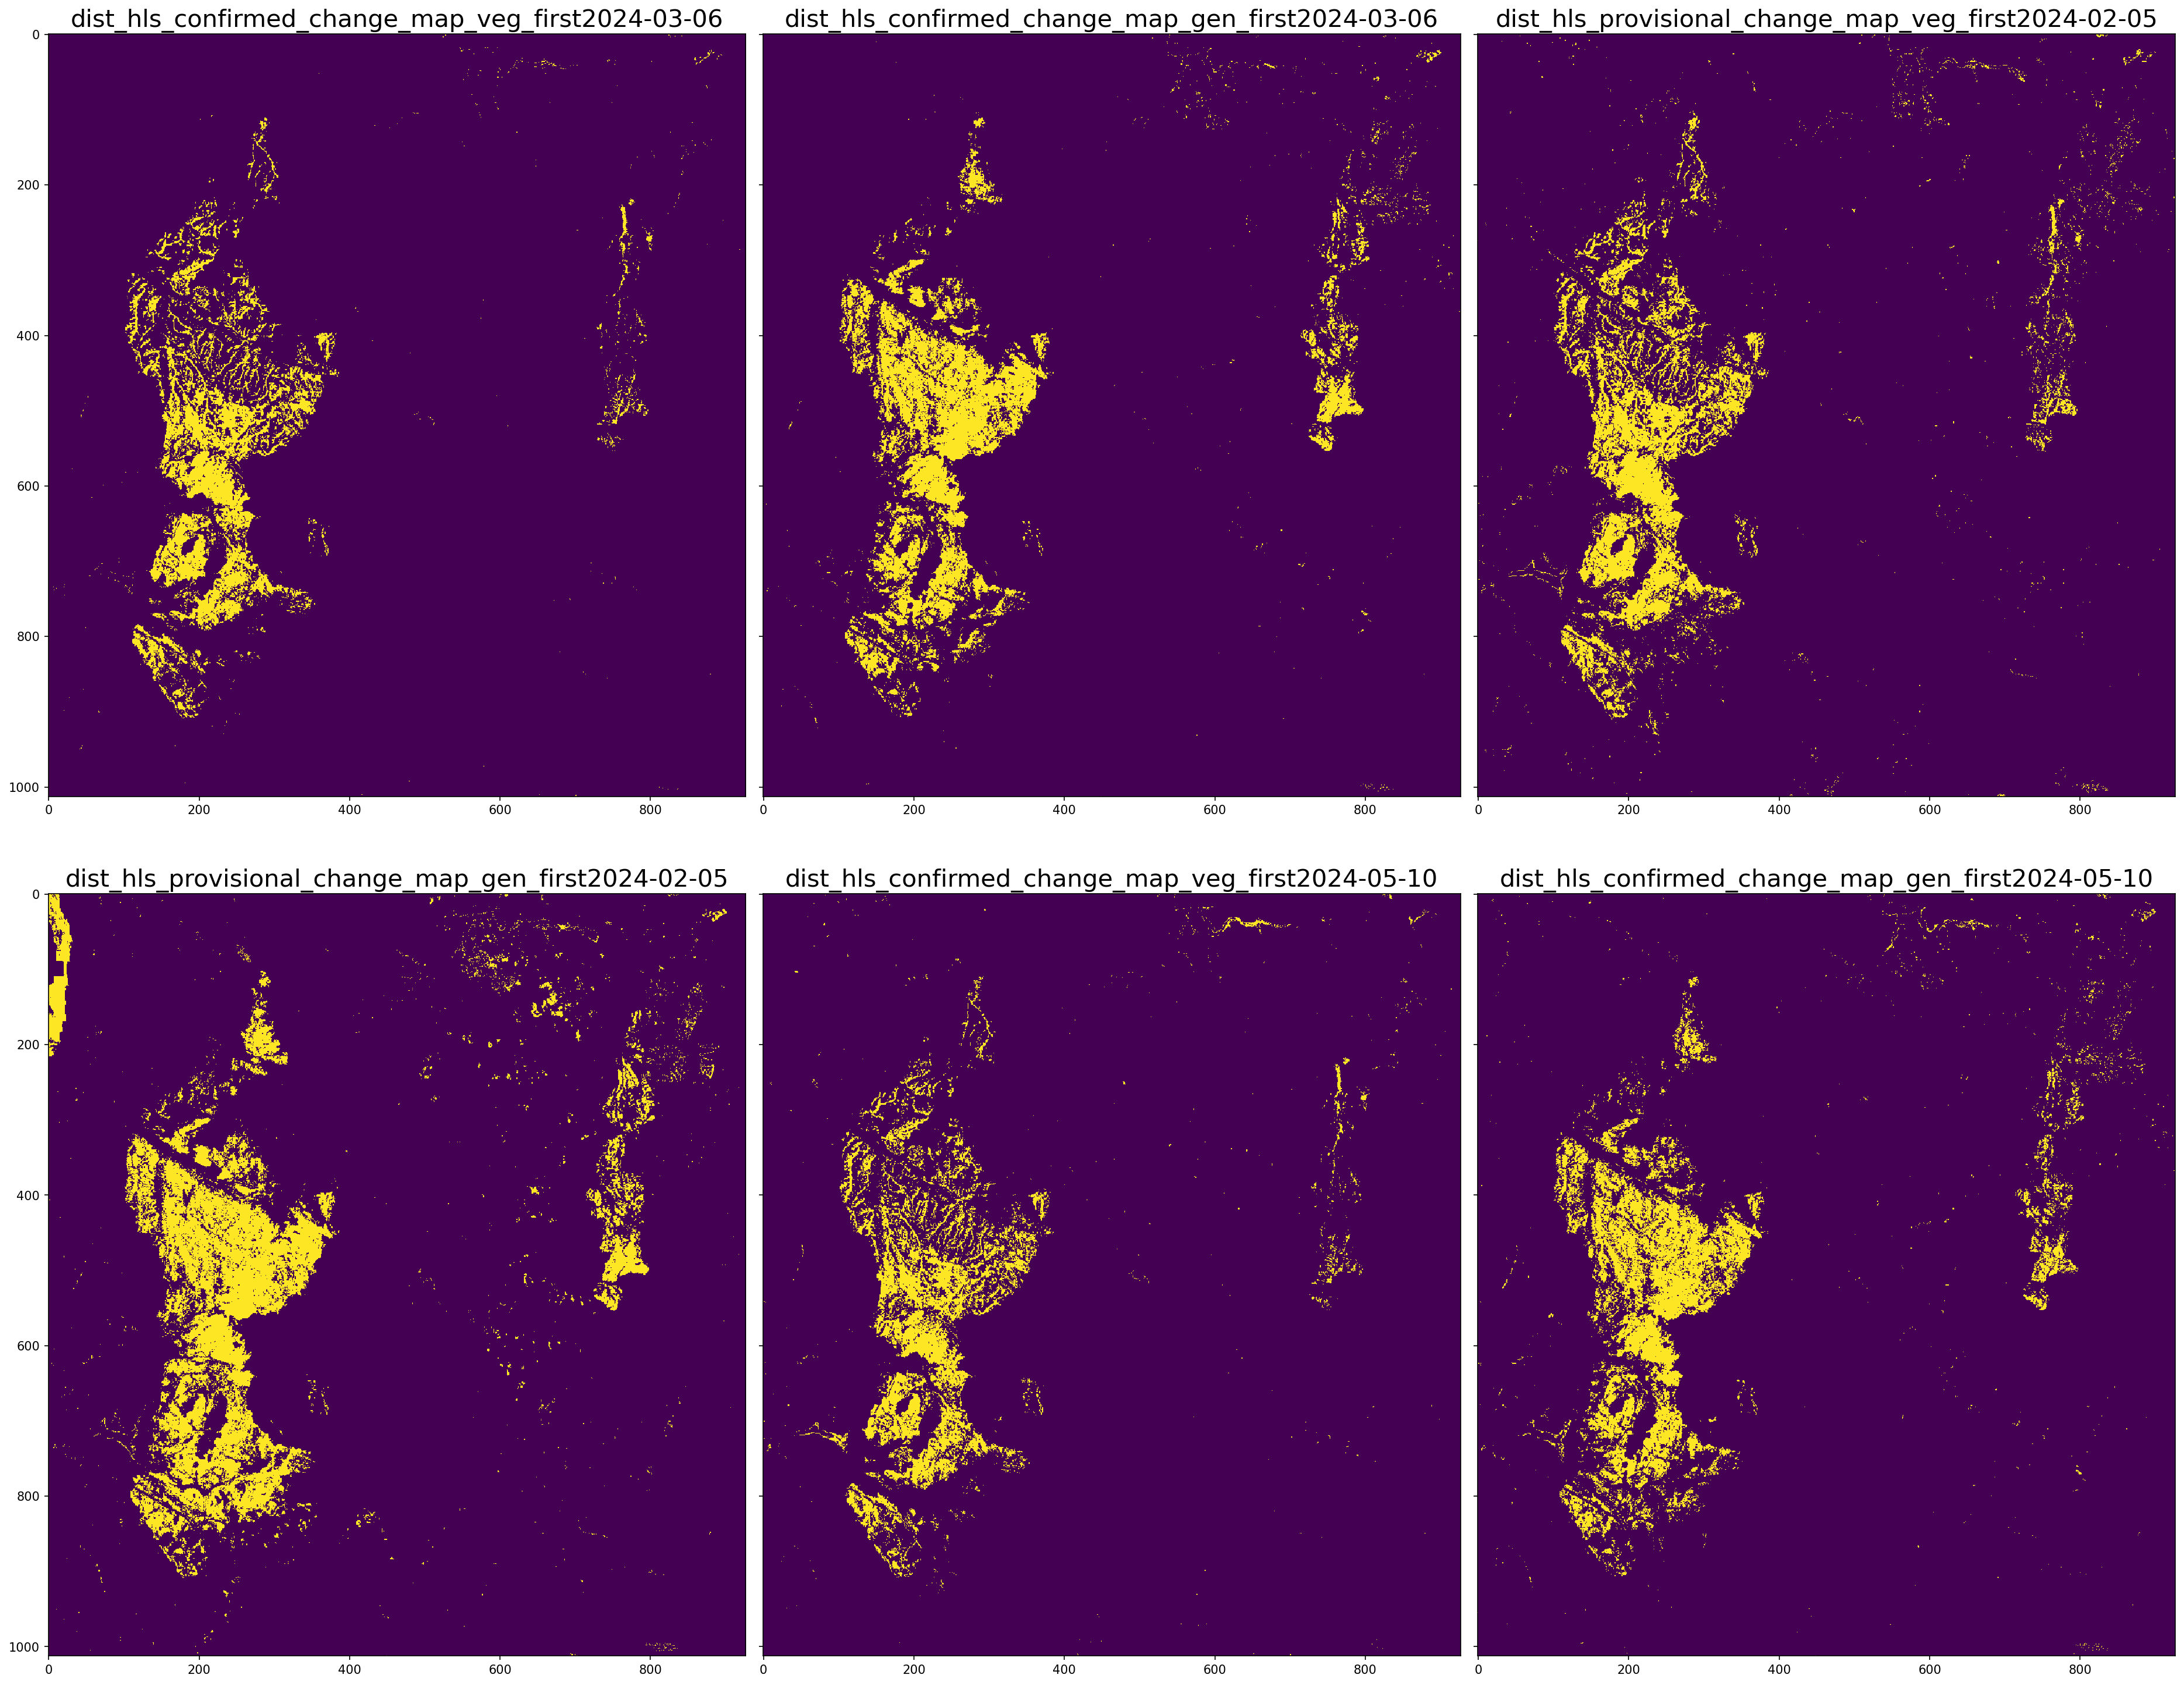

In [179]:
# Dist-HLS overview zoom
N = len(dist_hls_list)
ncols = math.ceil(N / 2) 
nrows = 2 

fig, axs = plt.subplots(nrows, ncols, figsize=(10 + ncols * 5, 10 + nrows * 5), dpi=150, sharey=True)

# Flatten axs if N is odd or if N doesn't divide equally into two rows
axs = axs.flatten()

for ax, met, mn in zip(axs, dist_hls_list, dist_hls_names):
    im = ax.imshow(met[s], vmin=0, vmax=1, interpolation='none')
    ax.set_title(mn, fontsize=20)

plt.tight_layout()
plt.show()

In [180]:
def plot_precision_recall_curves(dist_hls_list, dist_hls_names, metric, metric_name):
    plt.figure(figsize=(10, 8))
    
    # Iterate over elements of dist_hls_list
    for i in range(len(dist_hls_list)):
        X_dist_cm = dist_hls_list[i]
        dist_hls_mask = ~np.isnan(metric)
        
        metric_dist = metric[dist_hls_mask]
        change_dist = X_dist_cm[dist_hls_mask]

        # Calculate precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(change_dist, metric_dist)

        # Calculate F1 score and find max
        f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-7)
        k_max = np.argmax(f1_scores)
        f1_max = f1_scores[k_max]

        # Plot precision-recall curve
        plt.plot(recalls[:-1], precisions[:-1], label=f'Curve {dist_hls_names[i]}')
        
        # Highlight max F1 score
        plt.scatter(recalls[k_max], precisions[k_max], marker='*', c='red', zorder=2)
        plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', 
                     (recalls[k_max] + 0.01, precisions[k_max] + 0.01))

    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc='lower left')
    plt.title(f'Precision-Recall Curves for {metric_name}')
    plt.show()

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_218452/1636259418.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.annotate(f'$\max(F_1)=${f1_max:1.2f}',


In [181]:
def plot_precision_recall_curves(dist_hls_list, dist_hls_names, metric, metric_name):
    plt.figure(figsize=(12, 5))
    
    # Define line styles and colors for better distinction
    colors = plt.cm.Dark2(np.linspace(0, 1, 6))
    line_styles = ['-', '--', '-.', ':', '-', '--']
    
    for i in range(6):
        X_dist_cm = dist_hls_list[i]
        dist_hls_mask = ~np.isnan(metric)
        
        metric_dist = metric[dist_hls_mask]
        change_dist = X_dist_cm[dist_hls_mask]

        # Calculate precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(change_dist, metric_dist)

        # Calculate F1 score and find max
        f1_scores = 2 * recalls * precisions / (recalls + precisions + 1e-7)
        k_max = np.argmax(f1_scores)
        f1_max = f1_scores[k_max]

        # Plot precision-recall curve with distinct color and style
        plt.plot(recalls[:-1], precisions[:-1], 
                 label=f'Curve {dist_hls_names[i]}', 
                 color=colors[i], linestyle=line_styles[i], lw=2)

        # Highlight max F1 score
        plt.scatter(recalls[k_max], precisions[k_max], marker='*', c='red', zorder=2, s=100)
        plt.annotate(f'$\max(F_1)=${f1_max:1.2f}', 
                     (recalls[k_max] + 0.01, precisions[k_max] + 0.01),
                     fontsize=12, color=colors[i])

    # Add labels, title, and limits
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.ylabel('Precision', fontsize=14)
    plt.xlabel('Recall', fontsize=14)
    plt.title(f'Precision-Recall Curves for {metric_name}', fontsize=16)

    # Adjust the legend location dynamically to place it in an empty region
    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5), fontsize=12, frameon=True)
    plt.legend(loc='upper right', fontsize=12, frameon=True)
    # Tighten the layout
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    # Show the plot
    plt.show()


<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_218452/2378400869.py:30: SyntaxWarning: invalid escape sequence '\m'
  plt.annotate(f'$\max(F_1)=${f1_max:1.2f}',


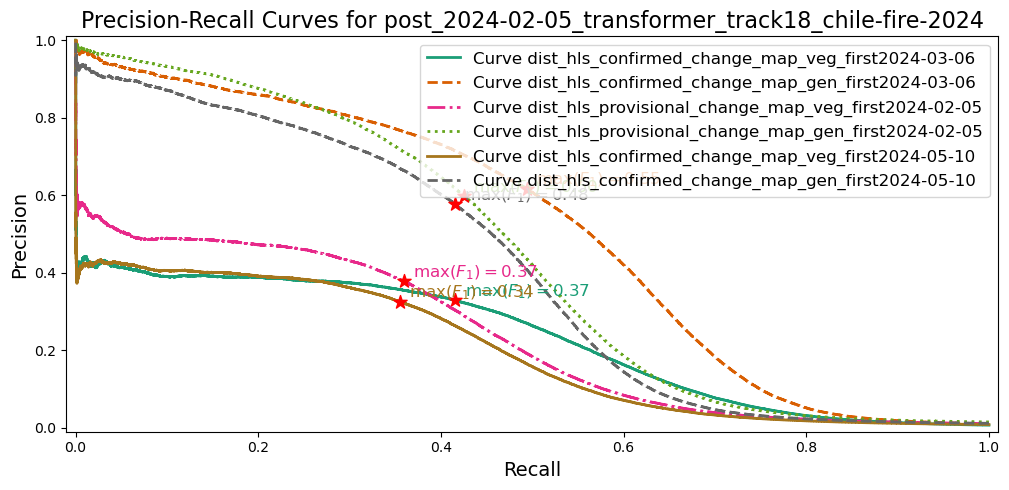

In [182]:
plot_precision_recall_curves(dist_hls_list, dist_hls_names,
                             post_metric_list[0], post_metric_names[0])

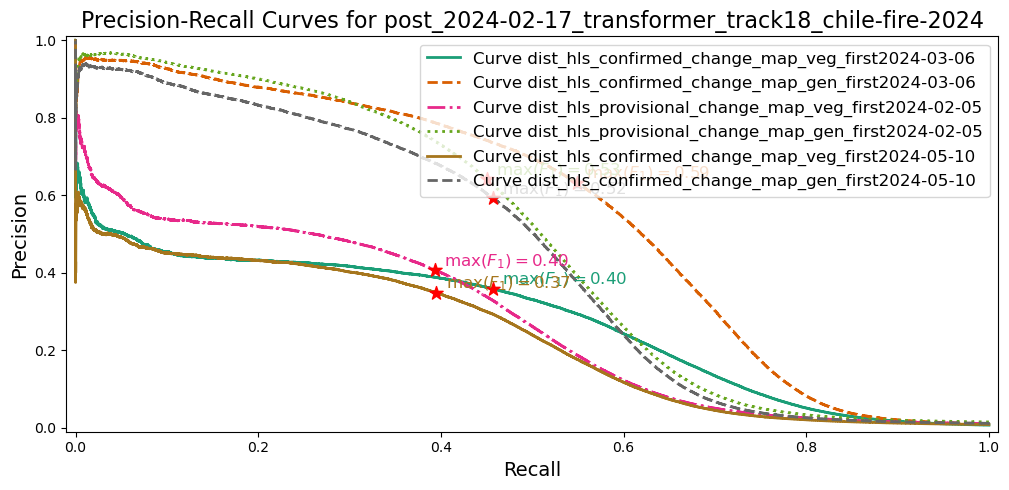

In [183]:
plot_precision_recall_curves(dist_hls_list, dist_hls_names,
                             post_metric_list[1], post_metric_names[1])

In [184]:
### Serialize obtained values